# 삼성 DS-KAIST AI Expert 프로그램
## Week 3: Autoencoder, VAE, GAN 과제

담당 조교: 박종진 (pjj4288@kaist.ac.kr)

## Introduction

주석으로 표시된 미구현 부분 (`compute_loss()` 함수)을 완성하고 그 결과를 확인해주세요.

본 과제에서는 실습시간 Part 2에서 다룬 GAN을 활용하여 운동화나 셔츠 같은 옷 이미지를 생성하는 모델을 만들어볼 것입니다. 여러가지 GAN 모델 중, class-conditioning이 가능한 모델인 ACGAN을 학습할 것입니다. 10개의 클래스와 70,000개의 흑백 이미지로 구성된 Fashion-MNIST 데이터셋을 사용하여 학습한 뒤 그 결과를 확인합니다. GAN의 generator가 tanh function을 activation으로 사용할 것이므로 GAN을 위한 전처리는 [-1, 1]로 normalize합니다. 

In [1]:
# 실습에서 사용할 모듈을 import 합니다.

# IPYthon 상에서 matplotlib 라이브러리가 
# 별도의 창 없이 즉시 plot을 출력할 수 있도록 설정을 변경합니다.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import time

# "즉시 실행" (eager execution) 기능을 활성화합니다.
# 즉시 실행 활성화로 TensorFlow를 대화형 프론트엔드(frontend)에 가깝게 만들어 줍니다.
# 해당 기능은 TensorFlow 2.0 부터는 기본적으로 활성화됩니다. 
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

Eager execution: True


In [2]:
# Fashion-MNIST 데이터셋은 TensorFlow에서 바로 불러올 수 있습니다.
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# 각 데이터 샘플은 0~9 사이의 값을 라벨로 가지고, 각 라벨과 실제 대응되는 옷 종류는 아래와 같습니다.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 불러온 데이터셋은 0~255 사이의 값을 가지는 흑백 이미지로 구성되어 있습니다.
# 네트워크의 안정적인 학습을 위해, 각 데이터가 0~1 사이의 값을 가지도록 전처리합니다.
# 이때, 훈련 데이터셋과 테스트 데이터셋을 같은 방식으로 전처리해주는 것이 중요합니다.
train_images = train_images / 255.0
test_images = test_images / 255.0

print('훈련 세트 수: {}'.format(len(train_labels)))
print('테스트 세트 수: {}'.format(len(test_labels)))
print('이미지 크기: %d x %d' % train_images.shape[1:])
print('레이블 형태: {}'.format(train_labels))


4423680/4422102 [==============================] - 1s 0us/step
훈련 세트 수: 60000
테스트 세트 수: 10000
이미지 크기: 28 x 28
레이블 형태: [9 0 0 ... 3 0 5]


In [3]:
# GAN을 위한 전처리 과정.
# generator의 마지막 activation function에 따라 전처리 과정이 달라집니다. 이번 실습에서는 tanh function을 사용하므로 [-1, 1] 범위로 normalize해줍니다.
train_images_gan = (train_images*2.) - 1. # Normalize the images from [0, 1] to [-1, 1]
test_images_gan = (test_images*2.) - 1. # Normalize the images from [0, 1] to [-1, 1]

In [4]:
# CNN을 input을 위한 이미지 reshape
train_images_gan = train_images_gan.reshape(train_images_gan.shape[0], 28, 28, 1).astype('float32')
test_images_gan = test_images_gan.reshape(test_images_gan.shape[0], 28, 28, 1).astype('float32')


In [5]:
# 이미지, 라벨은 각각 numpy.array의 형태로 임포트됩니다.
# 효과적인 학습 구성을 위헤, 1) 이미지, 라벨 쌍을 배치 형태로 묶는 것과 2) 각 배치를 tf.tensor로 변환하는 과정을 수행합니다.
# 이 과정은 tf.data.Dataset 높은 수준의 class를 통해서 쉽게 처리될 수 있습니다.
train_ds_gan = tf.data.Dataset.from_tensor_slices((train_images_gan, train_labels)).shuffle(60000).batch(64)
test_ds_gan = tf.data.Dataset.from_tensor_slices((test_images_gan, test_labels)).batch(64)

### Auxiliary-Classifier Generative Adversarial Networks (ACGAN)

실습시간 Part 2에서 다룬 GAN을 구현하여 Fashion-MNIST 데이터셋을 생성하는 컨볼루션 신경망 모델을 구성하고 학습합니다. 그 과정에서 GAN의 objective와 이것이 무엇을 최적화하는지, 그리고 실제 학습이 어떤 방식으로 이루어지는지 이론과의 차이점을 파악하는 것이 목적입니다. 실습시간과 마찬가지로 더 깊게 신경망을 쌓아 성능을 향상시킨 Deep Convolutional GAN (DCGAN)을 사용하게 될 것입니다.

아래에 DCGAN architecture를 사용한 generator / discriminator가 구현되어 있습니다. 각 layer를 통과할 때마다 output tensor의 크기가 어떻게 변하는지 생각해보세요. 또한 ACGAN을 위한 layer가 어떤 것이 추가되었는지도 확인해보세요.

In [6]:
epochs = 15
batch_size = 64
noise_dim = 100
num_classes = 10
num_examples_to_generate = 25

In [7]:
def generate_and_save_images_gan(model, epoch, test_noise, test_cls, test=False):
  test_cls_onehot = tf.keras.utils.to_categorical(test_cls, num_classes)
  gen_images = model([test_noise, test_cls_onehot])

  gen_images = gen_images/2 + 0.5 # Normalize the images from [-1, 1] to [0, 1]

  fig = plt.figure(figsize=(5,5))

  for i in range(gen_images.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(gen_images[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  if test:
      plt.savefig('GAN_image_acgan.png')
  else:
      plt.savefig('GAN_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Deep Convolutional GAN (DCGAN)

DCGAN의 구조적 특징은 다음과 같습니다. 각각의 특성들은 학습을 안정화시켜 결과적으로 생성 능력을 향상시킵니다.
* 각각 `Conv2DTranspose` / `Conv2D` layer를 generator / discriminator에 사용. 
* 각각 `ReLU` / `LeakyReLU` 함수를 generator / discriminator의 activation으로 사용. 이 때, LeakyReLU의 기울기 (slope)는 0.2. 
* `BatchNormalizaiton` 을 generator / discriminator 둘 모두에 사용.

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(L.Dense(7*7*256, use_bias=False, input_shape=(noise_dim+num_classes,)))
    model.add(L.BatchNormalization())
    model.add(L.ReLU())
    model.add(L.Reshape((7, 7, 256)))

    model.add(L.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(L.BatchNormalization())
    model.add(L.ReLU())

    model.add(L.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(L.BatchNormalization())
    model.add(L.ReLU())

    model.add(L.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    # for ACGAN
    # this is the random noise commonly referred to in GAN papers
    z = L.Input(shape=(noise_dim, ))
    # this will be our label
    y = L.Input(shape=(num_classes,))
    
    fake = model(L.concatenate([z,y]))

    return tf.keras.Model([z, y], fake)

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(L.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1], use_bias=False))
    model.add(L.LeakyReLU(alpha=0.2))
    
    model.add(L.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(alpha=0.2))
    
    model.add(L.Conv2D(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(alpha=0.2))

    model.add(L.Flatten())

    # for ACGAN
    image = L.Input(shape=(28, 28, 1))
    features = model(image)

    # first output (name=discriminator) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks
    disc = L.Dense(1, name='discriminator')(features)
    aux = L.Dense(num_classes, name='auxiliary')(features)

    return tf.keras.Model(image, [disc, aux])

In [14]:
generator = make_generator_model()
discriminator = make_discriminator_model()

print("===== Generator =====")
generator.summary()
print("===== Discriminator =====")
discriminator.summary()

===== Generator =====
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 28, 28, 1)    2456384     conca

### Q. ACGAN Loss & Training

본래 GAN의 목표는 다음과 같습니다. 강의에서 배우신 바와 같이, GAN을 학습할 때는 generator와 discriminator를 번갈아가며 학습합니다. 
* GAN의 objective.
<img src="resource/gan_obj.png">

강의시간에 다룬 Conditional GAN 중의 하나인 Auxiliary-Classifier GAN (ACGAN)은 다음과 같이 class label에 대한 classification loss를 같이 학습합니다.
* ACGAN 개요.
<img src="resource/acgan.png">

ACGAN의 objective는 다음과 같습니다.
* log-likelihood of the correct source.
<img src="resource/acgan_disc_loss.png">

* log-likelihood of the correct class.
<img src="resource/acgan_gen_loss.png">

ACGAN의 discriminator는 `L_s+L_c`를 최대화하는 방향으로, generator는 `-L_s+L_c`를 최대화하는 방향으로 학습합니다. 즉, 원래의 GAN objective인 `L_s`에 대해서는 변함없이 경쟁 관계가 되고, classification loss인 `L_c`에 대해서는 협력을 하는 셈입니다.

이제 아래 주어진 binary cross entropy, categorical cross entropy 함수를 사용하여 discriminator와 generator의 loss를 계산해보세요. loss는 학습하면서 줄여야 할 대상인 것에 유의하세요.
activation, optimizer, loss criterion 등을 변경하고 싶으실 경우 주석으로 언급해주시고 다른 것을 사용하셔도 됩니다.

구현한 손실 함수를 이용하여 GAN의 training step을 완성하세요. 원래의 GAN loss는 실습 시간의 코드를 재사용하셔도 되고, ACGAN에서 추가로 필요한 loss만 구현하시면 됩니다.

In [15]:
# loss를 위한 cross entropy criterion
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cls_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [18]:
def compute_loss(discriminator, generator, x, y):
  y_onehot = tf.keras.utils.to_categorical(y, num_classes)
  noise = tf.random.normal([batch_size, noise_dim])
  y_fake = tf.random.uniform([batch_size, ],0,num_classes, dtype=tf.dtypes.int32)
  y_onehot_fake = tf.keras.utils.to_categorical(y_fake, num_classes)
  
  ##### 여기에 코드를 작성하세요 #####
    
  disc_loss = discriminator_loss(y_onehot, y_onehot_fake)
  gen_loss = generator_loss(y_onehot_fake) - disc_loss

  return disc_loss, gen_loss

def compute_gradients_gan(discriminator, generator, x, y):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    disc_loss, gen_loss = compute_loss(discriminator, generator, x, y)

  return disc_tape.gradient(disc_loss, discriminator.trainable_variables), gen_tape.gradient(gen_loss, generator.trainable_variables)

def apply_gradients(optimizer, gradients, variables):
  optimizer.apply_gradients(zip(gradients, variables))

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
random_vector_for_generation = tf.random.normal([num_examples_to_generate, noise_dim])
random_cls_for_generation = tf.random.uniform([num_examples_to_generate, ],0,num_classes, dtype=tf.dtypes.int32)

### ACGAN 학습 과정 확인

이제 구성된 `ACGAN`의 `generator`와 `discriminator`를 학습할 수 있습니다. 학습과정은 아래와 같으며, 각 epoch이 끝날 때마다 생성 이미지를 확인할 수 있도록 했습니다. 훈련 예상시간은 약 40분입니다. 학습이 충분히 이루어졌다고 판단될 경우 (i.e. 이미지 퀄리티가 납득 가능할 정도로 좋을 경우) 끝까지 기다리시지 않고 중단하셔도 좋습니다. 각 epoch 끝에서 이미지가 `GAN_image_at_epoch_xxxx.png`의 형태로 저장되는데, 이를 지우지 마시고 제출 폴더에 남겨주세요.

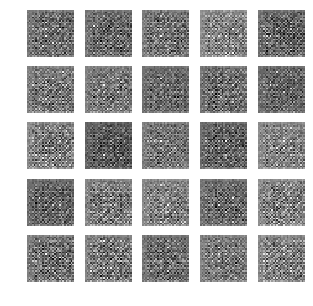

ValueError: No gradients provided for any variable: ['conv2d_3/kernel:0', 'conv2d_4/kernel:0', 'batch_normalization_8/gamma:0', 'batch_normalization_8/beta:0', 'conv2d_5/kernel:0', 'batch_normalization_9/gamma:0', 'batch_normalization_9/beta:0', 'discriminator_1/kernel:0', 'discriminator_1/bias:0', 'auxiliary_1/kernel:0', 'auxiliary_1/bias:0'].

In [22]:
generate_and_save_images_gan(generator, 0, random_vector_for_generation, random_cls_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x, train_y in train_ds_gan:
    disc_gradients, gen_gradients = compute_gradients_gan(discriminator, generator, train_x, train_y)
    apply_gradients(discriminator_optimizer, disc_gradients, discriminator.trainable_variables)
    apply_gradients(generator_optimizer, gen_gradients, generator.trainable_variables)

  end_time = time.time()

  if epoch % 1 == 0:
    print('Epoch: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    end_time - start_time))
    generate_and_save_images_gan(
        generator, epoch, random_vector_for_generation, random_cls_for_generation)

### Sample Image Check
이제 학습된 ACGAN으로 원하는 특정 클래스를 골라서 생성할 수 있습니다. 아래는 첫 번째 클래스인 `T-shirt/top` 에 대한 이미지를 생성하는 코드입니다. 제대로 모델이 훈련되었다면 티셔츠 이미지가 생성될 것입니다. 생성된 이미지는 같은 디렉토리의 `GAN_image_acgan.png`라는 이름으로 저장됩니다. 이를 지우지 마시고 제출 폴더에 남겨주세요.

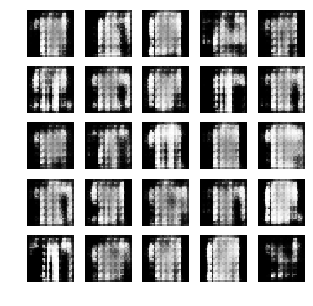

In [18]:
test_vector_for_generation = tf.random.normal([num_examples_to_generate, noise_dim])
test_cls_for_generation = tf.random.uniform([num_examples_to_generate, ],0,1, dtype=tf.dtypes.int32) # class label is 0 ('T-shirt/top')
generate_and_save_images_gan(generator, 0, test_vector_for_generation, test_cls_for_generation, test=True)
